In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
from myutils.common import yaml_util
from utils import module_util, net_measure_util

In [2]:
config_file_path = '../config/densenet169.yaml'
config = yaml_util.load_yaml_file(config_file_path)
input_shape = config['input_shape']
model = module_util.get_model(config, 'cpu')

In [3]:
modules = list()
module_util.extract_decomposable_modules(model, torch.rand(input_shape).unsqueeze(0), modules)

(tensor([[-0.3376,  0.1123, -0.2044, -0.3712, -0.2982, -0.1796,  0.1114, -0.4234,
           0.5732, -0.3868, -0.0270, -0.1302, -0.1028,  0.0478, -0.3072, -0.6937,
           0.6587, -0.3447, -0.1998, -0.5454, -1.4678, -0.1422, -0.1996, -0.0800,
          -0.1312,  0.2439,  0.0038,  1.4753,  0.0513,  1.0483, -0.8786, -0.1157,
           0.4205, -0.4605, -0.8914,  0.4197, -0.1317,  0.9236,  0.5786,  0.7481,
          -0.2718, -0.4613,  0.0370,  0.2227,  0.9472,  0.9720,  0.2798, -0.2989,
          -0.2093, -0.3081,  0.3016,  0.2658, -0.4117,  0.5475, -0.2694,  0.5993,
           0.3960,  0.1037,  0.5961, -0.3188,  0.5375, -0.3901,  0.0052, -0.8750,
          -0.2050, -0.5514,  0.6826, -0.3270,  0.0768, -1.3083,  0.0779,  0.2450,
           0.7740,  0.3865,  0.3858,  0.2779,  0.7294, -0.0818, -0.5852, -0.2943,
           0.2725,  1.1190, -0.4263,  0.0605,  0.2052,  0.4316, -0.2073,  0.3669,
           0.4732, -0.0418, -1.1266, -0.1481, -0.3679,  0.9459,  0.4749, -0.0982,
          -0.253

In [4]:
for i, module in enumerate(modules):
    print(i, type(module).__name__)

0 Conv2d
1 BatchNorm2d
2 ReLU
3 MaxPool2d
4 _DenseLayer
5 _DenseLayer
6 _DenseLayer
7 _DenseLayer
8 _DenseLayer
9 _DenseLayer
10 BatchNorm2d
11 ReLU
12 Conv2d
13 AvgPool2d
14 _DenseLayer
15 _DenseLayer
16 _DenseLayer
17 _DenseLayer
18 _DenseLayer
19 _DenseLayer
20 _DenseLayer
21 _DenseLayer
22 _DenseLayer
23 _DenseLayer
24 _DenseLayer
25 _DenseLayer
26 BatchNorm2d
27 ReLU
28 Conv2d
29 AvgPool2d
30 _DenseLayer
31 _DenseLayer
32 _DenseLayer
33 _DenseLayer
34 _DenseLayer
35 _DenseLayer
36 _DenseLayer
37 _DenseLayer
38 _DenseLayer
39 _DenseLayer
40 _DenseLayer
41 _DenseLayer
42 _DenseLayer
43 _DenseLayer
44 _DenseLayer
45 _DenseLayer
46 _DenseLayer
47 _DenseLayer
48 _DenseLayer
49 _DenseLayer
50 _DenseLayer
51 _DenseLayer
52 _DenseLayer
53 _DenseLayer
54 _DenseLayer
55 _DenseLayer
56 _DenseLayer
57 _DenseLayer
58 _DenseLayer
59 _DenseLayer
60 _DenseLayer
61 _DenseLayer
62 BatchNorm2d
63 ReLU
64 Conv2d
65 AvgPool2d
66 _DenseLayer
67 _DenseLayer
68 _DenseLayer
69 _DenseLayer
70 _DenseLayer
7

In [5]:
def find_bottleneck_layers(x, start_idx, modules):
    bottleneck_list = list()
    org_size = np.prod(x.size())
    for i in range(start_idx, len(modules)):
        teacher_model = nn.Sequential(*modules[start_idx:i])
        z = teacher_model(x)
        rate = np.prod(z.size()) / org_size
        if rate < 1.0:
            bottleneck_list.append((i, type(modules[i]).__name__, rate, z.size()))
    return bottleneck_list

In [6]:
x = torch.ones(1, *input_shape)
start_idx = 0
end_idx = 14
teacher_model = nn.Sequential(*modules[start_idx:end_idx])
z = teacher_model(x)
z.size()

torch.Size([1, 128, 28, 28])

In [7]:
student_model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 128, kernel_size=2, stride=1, bias=False),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
)
z = student_model(x)
z.size()

torch.Size([1, 128, 28, 28])

In [8]:
find_bottleneck_layers(x, start_idx, modules)

[(14, '_DenseLayer', 0.6666666666666666, torch.Size([1, 128, 28, 28])),
 (15, '_DenseLayer', 0.8333333333333334, torch.Size([1, 160, 28, 28])),
 (30, '_DenseLayer', 0.3333333333333333, torch.Size([1, 256, 14, 14])),
 (31, '_DenseLayer', 0.375, torch.Size([1, 288, 14, 14])),
 (32, '_DenseLayer', 0.4166666666666667, torch.Size([1, 320, 14, 14])),
 (33, '_DenseLayer', 0.4583333333333333, torch.Size([1, 352, 14, 14])),
 (34, '_DenseLayer', 0.5, torch.Size([1, 384, 14, 14])),
 (35, '_DenseLayer', 0.5416666666666666, torch.Size([1, 416, 14, 14])),
 (36, '_DenseLayer', 0.5833333333333334, torch.Size([1, 448, 14, 14])),
 (37, '_DenseLayer', 0.625, torch.Size([1, 480, 14, 14])),
 (38, '_DenseLayer', 0.6666666666666666, torch.Size([1, 512, 14, 14])),
 (39, '_DenseLayer', 0.7083333333333334, torch.Size([1, 544, 14, 14])),
 (40, '_DenseLayer', 0.75, torch.Size([1, 576, 14, 14])),
 (41, '_DenseLayer', 0.7916666666666666, torch.Size([1, 608, 14, 14])),
 (42, '_DenseLayer', 0.8333333333333334, torch.

Number of Operations: 3399.00887M


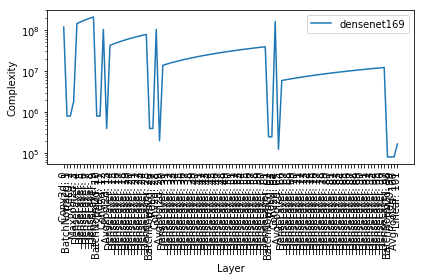

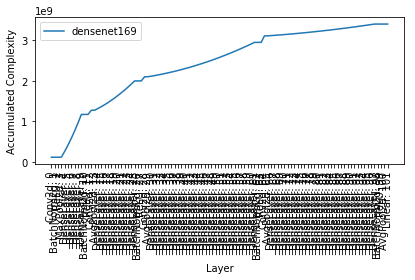

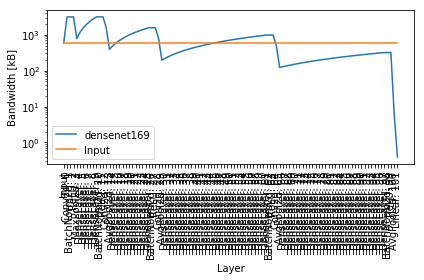

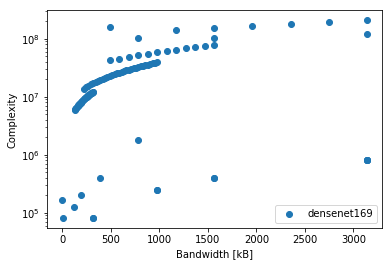

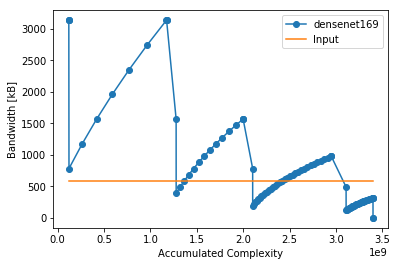

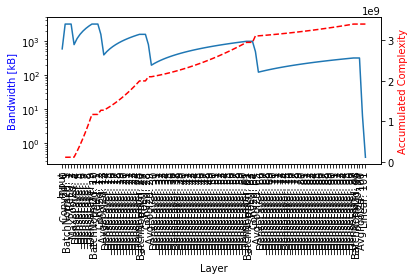

In [9]:
op_count_list, bandwidths, accum_complexities = net_measure_util.compute_model_complexity_and_bandwidth(model, config['model']['type'], input_shape, scaled=False)